In [1]:
import pymc as pm
import numpy as np
import arviz as az
import pandas as pd
import aesara.tensor.subtensor as st
from itertools import combinations

%load_ext lab_black
%load_ext watermark

# Simvastatin

This one is about factorial designs (2-way ANOVA) with sum-to-zero and corner constraints.

Adapted from [Unit 7: simvastatin.odc](https://raw.githubusercontent.com/areding/6420-pymc/main/original_examples/Codes4Unit7/simvastatin.odc).

Data can be found [here](https://raw.githubusercontent.com/areding/6420-pymc/main/data/simvastatin_data.txt).


Associated lecture videos: Unit 8 lessons 8 and 9

## Problem statement
In a quantitative physiology lab II at Georgia Tech, students were asked to find a therapeutic model to test on MC3T3-E1 cell line to enhance osteoblastic growth. The students found a drug called Simvastatin, a cholesterol lowering drug to test on these cells. Using a control and three different concentrations: 10^-9, 10*-8 and 10-7 M, cells were treated with the drug. These cells were plated on four, 24 well plates with each well plate having a different treatment. To test for osteoblastic differentiation an assay, pNPP, was used to test for alkaline phosphatase activity. The higher the alkaline phosphatase activity the better the cells are differentiating, and become more bone like. This assay was performed 6 times total within 11 days. Each time the assay was performed, four wells from each plate were used.

notes: 

love this explanation of stz constraints:
https://stats.stackexchange.com/questions/257778/sum-to-zero-constraint-in-one-way-anova

In [4]:
data = pd.read_csv("../data/simvastatin_data.tsv", sep="\t")

In [5]:
data

,apa,conc,time
0,0.062,1,1
1,0.517,1,1
2,0.261,1,1
3,0.154,1,1
4,0.071,2,1
...,...,...,...
91,0.085,3,6
92,0.290,4,6
93,0.090,4,6
94,0.518,4,6


In [6]:
y = data["apa"].to_numpy()

In [7]:
# set up alternate coordinates, the ID3 or clusters column
conc_idx, conc = pd.factorize(data["conc"])
time_idx, time = pd.factorize(data["time"])
coords = {"conc": conc, "id": data.index.to_numpy(), "time": time}

In [8]:
coords

{'conc': Int64Index([1, 2, 3, 4], dtype='int64'),
 'id': array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
        51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
        68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84,
        85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95]),
 'time': Int64Index([1, 2, 3, 4, 5, 6], dtype='int64')}

In [9]:
conc_idx, conc

(array([0, 0, 0, 0, 1, 1, 1, 1, 2, 2, 2, 2, 3, 3, 3, 3, 0, 0, 0, 0, 1, 1,
        1, 1, 2, 2, 2, 2, 3, 3, 3, 3, 0, 0, 0, 0, 1, 1, 1, 1, 2, 2, 2, 2,
        3, 3, 3, 3, 0, 0, 0, 0, 1, 1, 1, 1, 2, 2, 2, 2, 3, 3, 3, 3, 0, 0,
        0, 0, 1, 1, 1, 1, 2, 2, 2, 2, 3, 3, 3, 3, 0, 0, 0, 0, 1, 1, 1, 1,
        2, 2, 2, 2, 3, 3, 3, 3]),
 Int64Index([1, 2, 3, 4], dtype='int64'))

In [10]:
time_idx

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5])

## Model 1 with sum-to-zero constraints

- why use stz constraints
- why set pm.Deterministic on later variables
- meaning of _ and use in az.summary
- dims and how they work
- why st.set_subtensor
- brief overview of indexing
- model speed and problem diagnosis

In [11]:
alpha_combos = list(combinations(range(len(conc)), 2))
beta_combos = list(combinations(range(len(time)), 2))

In [12]:
with pm.Model(coords=coords) as m:
    apa_data = pm.Data("apa_data", y, mutable=False)
    time_idx_data = pm.Data("time_idx_data", time_idx, dims="id", mutable=False)
    conc_idx_data = pm.Data("conc_idx_data", conc_idx, dims="id", mutable=False)

    mu0 = pm.Normal("mu0", 0, tau=0.0001)
    _alpha = pm.Normal("_alpha", 0, tau=0.0001, dims="conc")
    _beta = pm.Normal("_beta", 0, tau=0.0001, dims="time")
    _alphabeta = pm.Normal("_alphabeta", 0, tau=0.0001, dims=("conc", "time"))
    tau = pm.Gamma("tau", 0.001, 0.001)
    sigma = pm.Deterministic("sigma", 1 / tau**0.5)

    # sum-to-zero constraints
    alpha = pm.Deterministic(
        "alpha",
        st.set_subtensor(_alpha[0], -_alpha[1:].sum(axis=0)),
    )
    beta = pm.Deterministic(
        "beta",
        st.set_subtensor(_beta[0], -_beta[1:].sum(axis=0)),
    )
    _alphabeta = st.set_subtensor(_alphabeta[:, 0], -_alphabeta[:, 1:].sum(axis=1))
    alphabeta = pm.Deterministic(
        "alphabeta", st.set_subtensor(_alphabeta[0, :], -_alphabeta[1:, :].sum(axis=0))
    )

    mu = (
        mu0
        + alpha[conc_idx_data]
        + beta[time_idx_data]
        + alphabeta[conc_idx_data, time_idx_data]
    )
    pm.Normal("apa", mu, tau=tau, observed=apa_data)

    [
        pm.Deterministic(f"alpha{i} - alpha{j}", alpha[i] - alpha[j])
        for i, j in alpha_combos
    ]
    [pm.Deterministic(f"beta{i} - beta{j}", beta[i] - beta[j]) for i, j in alpha_combos]

    trace = pm.sample(2000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu0, _alpha, _beta, _alphabeta, tau]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 59 seconds.


In [13]:
az.summary(trace, var_names="~_", filter_vars="like", kind="stats")

,mean,sd,hdi_3%,hdi_97%
mu0,0.238,0.025,0.193,0.286
tau,17.208,2.789,12.283,22.755
sigma,0.243,0.020,0.204,0.279
alpha[0],0.049,0.044,-0.032,0.132
alpha[1],0.069,0.043,-0.016,0.146
alpha[2],-0.075,0.043,-0.155,0.005
alpha[3],-0.043,0.043,-0.122,0.038
beta[0],0.046,0.055,-0.057,0.151
beta[1],-0.150,0.057,-0.257,-0.043
beta[2],-0.017,0.057,-0.124,0.089


array([<AxesSubplot:title={'center':'94.0% HDI'}>], dtype=object)

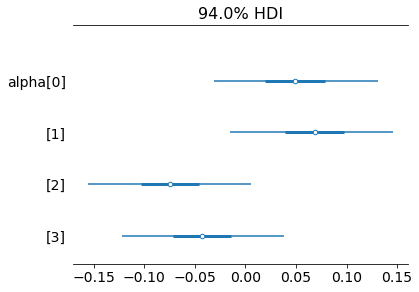

In [14]:
az.plot_forest(trace, var_names=["alpha"], combined=True)

array([<AxesSubplot:title={'center':'94.0% HDI'}>], dtype=object)

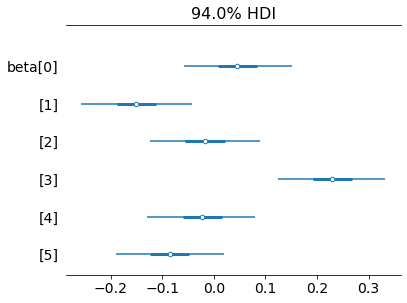

In [15]:
az.plot_forest(trace, var_names=["beta"], combined=True)

array([<AxesSubplot:title={'center':'94.0% HDI'}>], dtype=object)

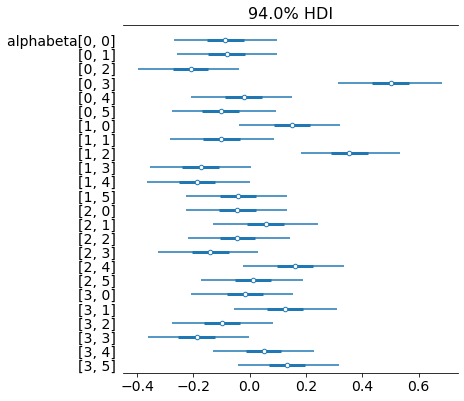

In [16]:
az.plot_forest(trace, var_names=["alphabeta"], combined=True)

## Model 2 with corner constraints

In [17]:
with pm.Model(coords=coords) as m:
    apa_data = pm.Data("apa_data", y, mutable=False)
    time_idx_data = pm.Data("time_idx_data", time_idx, dims="id", mutable=False)
    conc_idx_data = pm.Data("conc_idx_data", conc_idx, dims="id", mutable=False)

    mu0 = pm.Normal("mu0", 0, tau=0.0001)
    _alpha = pm.Normal("_alpha", 0, tau=0.0001, dims="conc")
    _beta = pm.Normal("_beta", 0, tau=0.0001, dims="time")
    _alphabeta = pm.Normal("_alphabeta", 0, tau=0.0001, dims=("conc", "time"))
    tau = pm.Gamma("tau", 0.001, 0.001)
    sigma = pm.Deterministic("sigma", 1 / tau**0.5)

    # corner constraints
    alpha = pm.Deterministic("alpha", st.set_subtensor(_alpha[0], 0))
    beta = pm.Deterministic("beta", st.set_subtensor(_beta[0], 0))
    _alphabeta = st.set_subtensor(_alphabeta[:, 0], 0)
    alphabeta = pm.Deterministic("alphabeta", st.set_subtensor(_alphabeta[0, :], 0))

    mu = (
        mu0
        + alpha[conc_idx_data]
        + beta[time_idx_data]
        + alphabeta[conc_idx_data, time_idx_data]
    )
    pm.Normal("apa", mu, tau=tau, observed=apa_data)

    [
        pm.Deterministic(f"alpha{i} - alpha{j}", alpha[i] - alpha[j])
        for i, j in alpha_combos
    ]
    [pm.Deterministic(f"beta{i} - beta{j}", beta[i] - beta[j]) for i, j in beta_combos]

    trace = pm.sample(2000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu0, _alpha, _beta, _alphabeta, tau]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 40 seconds.


In [18]:
az.summary(trace, var_names="~_", filter_vars="like", kind="stats")

,mean,sd,hdi_3%,hdi_97%
mu0,0.248,0.123,0.014,0.478
tau,17.110,2.912,11.770,22.554
sigma,0.244,0.021,0.205,0.283
alpha[0],0.000,0.000,0.000,0.000
alpha[1],0.257,0.173,-0.051,0.601
alpha[2],-0.084,0.174,-0.411,0.245
alpha[3],-0.024,0.172,-0.346,0.307
beta[0],0.000,0.000,0.000,0.000
beta[1],-0.192,0.171,-0.525,0.116
beta[2],-0.187,0.171,-0.495,0.144


In [19]:
%watermark -n -u -v -iv -p aesara,aeppl

Python implementation: CPython
Python version       : 3.10.4
IPython version      : 8.4.0

pandas: 1.4.2
pymc  : 4.0.0
aesara: 2.6.6
numpy : 1.22.4
arviz : 0.12.1

